<img src="final_scheme.png">

#### 1. Image acquisition 
#### 2. Image registration
#### 3. Deep learning vessel segmentation
- Input : conj raw images
- Description : Deep learning segmenation (previously ready)
- Output : conj segmented images  

#### 4. Generate template image utilize vessel morphological features
- Input : Segmented conj images
- Description :  
- 4.1. Centerline extractions
    - Input : conj segmented images
    - Description : genereate centerline images 
    - Output : conj skelelton images
- 4.2. Bifurcation points detections
    - Input : conj skelelton images
    - Description : find bifurcation points
    - Output : Removed branch points imgs, bifurcation points coordinates 
- 4.3. Get vessel length using connected components
    - Input : Removed branch points imgs
    - Description : labeling each vessels using connected components
    - Output : Labeled each skel vessels imgs, each vessels length infomations
- 4.4. Distance map  
    - Input : conj segmented images, Labeled each skel vessels imgs
    - Description : Get distance map and samplling
    - Output : Distance map each vessels
- 4.5. Weight function (length + distance)
    - Input : Each vessels length infomations, Distance map each vessels
    - Description : a*Mean(Norm length) + b*Mean(Norm distance)
    - Output : sorted template vessels images
- Output : Sorted template vessels images  

#### 5. Motion compensation using template matching
- Input : Sorted template vessels images (Best template), Each conj raw frames
- Description : Template maching and motion compensation
- 5.1. Template matching each frames
    - Input : Sorted template vessels images (Best template), Each conj raw frames
    - Description : Do template matching algoritm and get results from each frames
    - Output : Each frame tempate matching results coordinates (Center coordinates)
- 5.2. Motion compensation using template matching coordinates
    - Input : Each frame tempate matching results coordinates, Each conj raw frames
    - Description : Motion compensation each frame based on first template matching results
    - Output : Motion compensated frames
- Output : Motion compensated frames

#### 6. Flowable vessel proposal based on temporal variance and length
- Input : Motion compensated frames, vessel centerline info(4.1), each vessels length infomations (4.3)
- Description : Get temporal variance (Intensity from frames) and Do proposal algorithm additionly vessel lengths
    - Proposal equation : a * Mean(Normalized temporal variance) + b * Mean(Normalized lengths) 
- 6.1. Get sub vessels (sorted from length)
    - Input : Sorted template vessels images (Best template), Each conj raw frames
    - Description : Do template matching algoritm and get results from each frames
    - Output : Each frame tempate matching results coordinates (Center coordinates)
- 6.2. Motion compensation using template matching coordinates
    - Input : Each frame tempate matching results coordinates, Each conj raw frames
    - Description : Motion compensation each frame based on first template matching results
    - Output : Motion compensated frames   
 
- Output : sorted flowable vessels and coordinates

#### 7. Spatial Temporal Analysis
- Input : sorted flowable vessels and coordinates
- Description : DO STA algorithm
- Output : genterat STA images each frames based on vessel informations

#### 8. Blood vessel velocity
- Input :
- Description : 
- Output :  

In [1]:
import os
import sys
import cv2
import numpy as np
from lib import quantification
from lib import help_functions
from scipy.ndimage.morphology import distance_transform_edt
import scipy.ndimage as ndi
from tqdm import tqdm
from matplotlib import pyplot as plt

import configparser


sys.path.insert(0, './lib/')


from skimage.data import binary_blobs
from skimage.morphology import medial_axis, skeletonize, skeletonize_3d,thin
from skimage import data
from skimage.util import invert
from skimage.morphology import remove_small_objects

### 3. Deep learning vessel segmentation
- Input : conj raw images
- Description : Deep learning segmenation (previously ready)
- Output : conj segmented images  


#### functions for deep learning vessel segmentation
- load original vessel map
- load vessel segmentation map
- count number of vessel seg map (global)
- get shape of imgs

In [2]:
def load_vessel_ori_map(ORI_PATH, num_imgs, shape_imgs, crop_flag = False, crop_size = None):
    img_h, img_w = shape_imgs[0], shape_imgs[1]
    ori_vessel_imgs = np.zeros((num_imgs, img_h, img_w,3),dtype=np.uint8)  
    print('[load ori] ori vessel shape : ', np.shape(ori_vessel_imgs))
    idx =0 
    #print('ori vessel imgs shape : ', np.shape(ori_vessel_imgs))
    for count, filename in enumerate(sorted(os.listdir(ORI_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            temp = cv2.imread(ORI_PATH + filename)
            #print('[load ori] temp : ', np.shape(temp))
            if crop_flag == True:
                # crop
                bias_crop_size = int(crop_size/2)
                #print('[load ori] bias crop : ',bias_crop_size)
                temp = cv2.resize(temp, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
                #print('[load ori] middle temp : ', np.shape(temp))
                temp = temp[bias_crop_size : -bias_crop_size, bias_crop_size : -bias_crop_size]
                #print('[load ori] after cropping : ', np.shape(temp))
                
            ori_vessel_imgs[idx] = temp.astype(np.uint8)
            idx = idx+1
            
    return ori_vessel_imgs

def load_vessel_seg_map(SEG_PATH, num_imgs, shape_imgs, thr_val = 100, crop_flag = False, crop_size = None):
    img_h, img_w = shape_imgs[0], shape_imgs[1]
    seg_vessel_imgs = np.zeros((num_imgs, img_h, img_w),dtype=np.uint8)    
    print('[load seg map] seg vessel imgs shape : ',np.shape(seg_vessel_imgs))
    idx =0 
    
    for count, filename in enumerate(sorted(os.listdir(SEG_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            temp = (cv2.imread(SEG_PATH + filename))[:,:,0]
            #print('[load seg map] seg path : ',np.shape(temp))
            if crop_flag == True:
                # crop
                #print('[load seg map] before resize seg : ', np.shape(temp))
                bias_crop_size = int(crop_size/2)
                temp = temp[bias_crop_size : -bias_crop_size, bias_crop_size : -bias_crop_size]
                #print('[load seg map]seg map : ',np.shape(temp))
            ret,thresh = cv2.threshold(temp,100,255,cv2.THRESH_BINARY)
            thresh = np.array(thresh,np.uint8)
            seg_vessel_imgs[idx] = thresh
            
            idx = idx+1
            
    return seg_vessel_imgs

def count_num_files(FILE_PATH):
    num_files = 0
    for count, filename in enumerate(sorted(os.listdir(FILE_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            num_files = num_files+1
    return num_files

def get_shape_of_imgs(SEG_PATH):
    for count, filename in enumerate(sorted(os.listdir(SEG_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            temp_imgs = cv2.imread(SEG_PATH + filename)
            return np.shape(temp_imgs)
                    
def crop_get_shape_of_imgs(SEG_PATH, crop_size):
    for count, filename in enumerate(sorted(os.listdir(SEG_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            temp_imgs = cv2.imread(SEG_PATH + filename)
            print('[crop] before crop image ', np.shape(temp_imgs))
            bias_crop_size = int(crop_size/2)
            print('[crop] bias_more_crop_size ',bias_crop_size)
            temp_imgs = temp_imgs[bias_crop_size : -bias_crop_size, bias_crop_size : -bias_crop_size, :]
            print('[crop] after crop image  ',np.shape(temp_imgs))
            return np.shape(temp_imgs)

before crop size :  (1848, 2208)
crop size :  (874, 1054)
[crop] before crop image  (924, 1104, 3)
[crop] bias_more_crop_size  25
[crop] after crop image   (874, 1054, 3)
SHAPE IMGS :  (874, 1054, 3)
[load ori] ori vessel shape :  (36, 874, 1054, 3)
[load seg map] seg vessel imgs shape :  (36, 874, 1054)


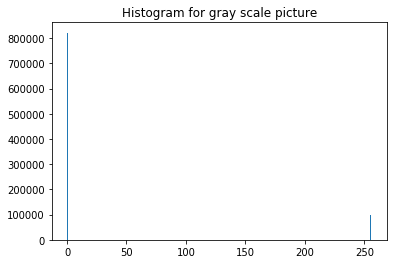

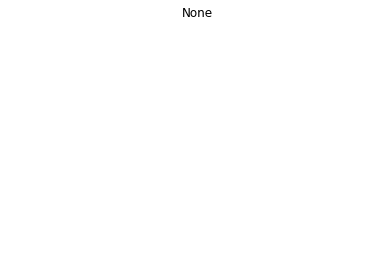

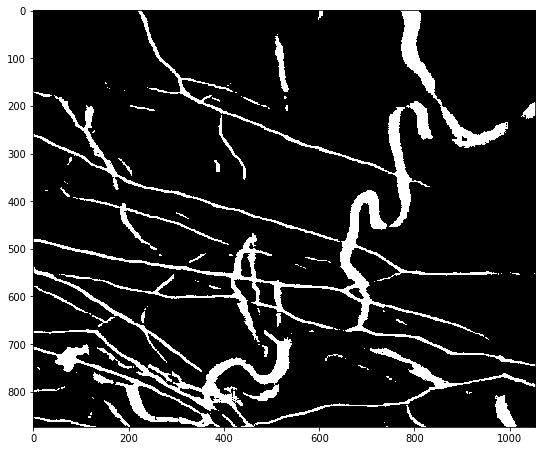

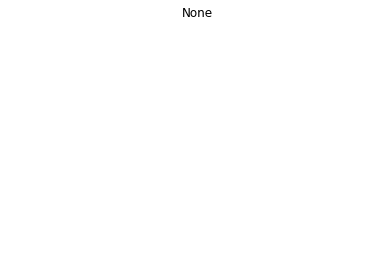

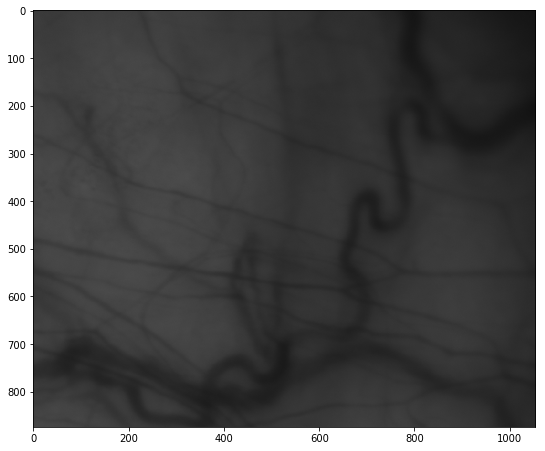

In [3]:
'''
Deep learning vessel segmentation

INPUT : segmentation imgs path (SEG_MAP_PATH)
OUTPUT : segmentation vessel imgs (SEG_VESSEL_IMGS)

'''
# Hyperparam
ORI_MAP_PATH =  './data/201130/proc_data/14_jmh/'
SEG_MAP_PATH = './result/201130/14_jmh/predicted_imgs/'

debug_flag = True
crop_flag = True
before_crop_size = (1848,2208)
#before_crop_size = (2054, 2456)
resize_factor = 0.5
bias_more_crop_size = 50

print('before crop size : ',before_crop_size)
crop_size = (int(before_crop_size[0] * resize_factor - bias_more_crop_size) , int(before_crop_size[1]*resize_factor - bias_more_crop_size))
print('crop size : ',crop_size)
# Input
#ORI_MAP_PATH = './data/20_01_31_video/06_video/'
#SEG_MAP_PATH = './result/conjunctival_result/20_03_25_CONJ_HRF01/predicted_imgs/'

#ORI_MAP_PATH = './data/20_01_31_video/03_video/'
#SEG_MAP_PATH = './result/conjunctival_result/20_03_25_CONJ_HRF01/predicted_imgs/'
config = configparser.RawConfigParser()
config.read('conj_configuration.txt')
# final result
name_experiment ='temp'
default_result_path = './result/'



NUM_ORI_IMGS = count_num_files(ORI_MAP_PATH)
NUM_SEG_IMGS = count_num_files(SEG_MAP_PATH)


if crop_flag == False:
    SHAPE_IMGS = get_shape_of_imgs(SEG_MAP_PATH)
    print(SHAPE_IMGS)
    # Output
    ORI_VESSEL_IMGS = load_vessel_ori_map(ORI_MAP_PATH,NUM_SEG_IMGS,SHAPE_IMGS)
    SEG_VESSEL_IMGS = load_vessel_seg_map(SEG_MAP_PATH,NUM_SEG_IMGS,SHAPE_IMGS)
    
else:
    SHAPE_IMGS = crop_get_shape_of_imgs(SEG_MAP_PATH, bias_more_crop_size)
    #SHAPE_IMGS = get_shape_of_imgs(SEG_MAP_PATH)
    print('SHAPE IMGS : ', SHAPE_IMGS)
    #SHAPE_IMGS = (770, 945, 3)
    # Output

    ORI_VESSEL_IMGS = load_vessel_ori_map(ORI_MAP_PATH,NUM_SEG_IMGS,SHAPE_IMGS, crop_flag, crop_size=bias_more_crop_size)
    SEG_VESSEL_IMGS = load_vessel_seg_map(SEG_MAP_PATH,NUM_SEG_IMGS,SHAPE_IMGS, crop_flag=crop_flag, crop_size=bias_more_crop_size)
        
    
if debug_flag == True:
    help_functions.show_histogram(SEG_VESSEL_IMGS[0],'gray')
    help_functions.show_on_jupyter(SEG_VESSEL_IMGS[0],'gray')
    help_functions.show_on_jupyter(ORI_VESSEL_IMGS[0])
    cv2.imwrite('seg_img.png',SEG_VESSEL_IMGS[0])
    cv2.imwrite('ori_img.png',ORI_VESSEL_IMGS[0])

##### 4. Generate template image utilize vessel morphological features
- Input : Segmented conj images
- Description :  
- 4.1. Centerline extractions
    - Input : conj segmented images
    - Description : genereate centerline images 
    - Output : conj skelelton images
- 4.2. Bifurcation points detections
    - Input : conj skelelton images
    - Description : find bifurcation points
    - Output : Removed branch points imgs, bifurcation points coordinates 
- 4.3. Get vessel length using connected components
    - Input : Removed branch points imgs
    - Description : labeling each vessels using connected components
    - Output : Labeled each skel vessels imgs, each vessels length infomations
- 4.4. Distance map  
    - Input : conj segmented images, Labeled each skel vessels imgs
    - Description : Get distance map and samplling
    - Output : Distance map each vessels
- 4.5. Weight function (length + distance)
    - Input : Each vessels length infomations, Distance map each vessels
    - Description : a*Mean(Norm length) + b*Mean(Norm distance)
    - Output : weighted value
    
- 4.6 getnerate template imgs 
    - Input : 
    - Description : 
    - Output : sorted template vessels images

- Output : Sorted template vessels images  

#### functions for generating template imgs
- centerline extraction
- bifurcation points
- connected components (length)
- distance map
- weight function


In [4]:
def centerline_extraction(thr_img):
    '''
    parameters
        thr_img : (boolean image)
            thresholded image
            
    return 
        skeleton image
    '''
    if np.max(thr_img) == 255:
        ret,thresh = cv2.threshold(thr_img,127,1,cv2.THRESH_BINARY)

    return skeletonize(thresh)

def _neighbors_conv(image):
    """
    Counts the neighbor pixels for each pixel of an image:
            x = [
                [0, 1, 0],
                [1, 1, 1],
                [0, 1, 0]
            ]
            _neighbors(x)
            [
                [0, 3, 0],
                [3, 4, 3],
                [0, 3, 0]
            ]
    :type image: numpy.ndarray
    :param image: A two-or-three dimensional image
    :return: neighbor pixels for each pixel of an image
    """
    image = image.astype(np.int)
    k = np.array([[1,1,1],[1,0,1],[1,1,1]])
    neighborhood_count = ndi.convolve(image,k, mode='constant', cval=1)
    neighborhood_count[~image.astype(np.bool)] = 0
    return neighborhood_count

def branches(image):
    """
    Returns the nodes in between edges
    Parameters
    ----------
    image : binary (M, N) ndarray
    Returns
    -------
    out : ndarray of bools
        image.
    """
    return _neighbors_conv(image) > 2

def extract_branch_cordi(branch_img):
    row, col = branch_img.shape
    #print(row, col)
    branch_list = []
    for i in range(0,row):
        for j in range(0,col):
            if branch_img[i,j] == True:
                branch_list.append([i,j])
                
    return branch_list

def draw_circle_branch_points_on_oriImg(ori_img, branch_points):
    '''
    parameters
        ori_img 
            original img, 
        branch_points
            branch points
        
    return 
        copy_img
            draw the circle on branch points
    '''
    copy_img = ori_img.copy()
    for i in range(len(branch_points)):
        tR,tC = branch_points[i]
        tR,tC = tC,tR
        tempRC = tuple([tR,tC])
        cv2.circle(copy_img,tempRC, 1,(0,255,0))
        
    return copy_img
    
def draw_circle_branch_points_on_skelImg(skel_img, branch_points):
    '''
    parameters
        skel_img 
            skeleton img from the vessel segmentaiton map 
        branch_points
            branch points
        
    return 
        copy_img
            draw the circle on branch points
    '''
    copy_skelImg = skel_img.copy()
    I = np.dstack([copy_skelImg.astype(np.uint8) * 255, copy_skelImg.astype(np.uint8) * 255, copy_skelImg.astype(np.uint8)* 255])
    for i in range(len(branch_points)):
        tR,tC = branch_points[i]
        tR,tC = tC,tR
        tempRC = tuple([tR,tC])
        cv2.circle(I,tempRC, 1,(0,255,0) )
        
    return I

def remove_branch_points(skel_img, branch_imgs):
    '''
    parameters
        skel_img
            skeleton image from segemnted image
            
        branch_img
            branch img (not branch points)
    
    return
        removedBranchImg
            divide from branch points
    '''
    
    skeleton = skel_img.copy()
    noBranch = np.invert(branch_imgs)
    removedBranchImg = np.bitwise_and(skeleton, noBranch)
    
    return removedBranchImg

def post_processing_skelImg(skel_img, connectivity_thr = 20):
    '''
    parameters
        skel_img
        connectivity_thr
        
    return 
        post_processed_skeleton
    '''
    skeleton = skel_img.copy()
    post_processed_skeleton = remove_small_objects(skeleton, connectivity= connectivity_thr)
    return post_processed_skeleton

def get_dist_map(seg_imgs, num_imgs, shape_imgs):
    dist_result = np.zeros((num_imgs, shape_imgs[0], shape_imgs[1]))
    for idx in range(num_imgs):
        dist_result[idx] = (2* distance_transform_edt(seg_imgs[idx]))
    return dist_result


def generating_template_imgs(labeled_img,distance_img,num_label, shape_img, top_k,a = 0.5, b= 0.5,template_rect_addi = 0.1):
    '''
    Input : labeled img (length), distance map (distance)
    1. sorting from length and distance
    2. get coordinates sorted vessels
    3. weigthed function (a*length + b*distance)
    4. based on top_k, generate template rectangle 
    Output : top_k template vessels

    Top-k

    max/min row,col
        각 image마다, 각 vessel마다 4개의 data를 저장해야 한다.
        shape => (num image, top-k,4)
        0,1 => max row / col // 2,3 => min row / col
        temp_max_min_lists[idx,0] = np.max(row)
        temp_max_min_lists[idx,1] = np.max(col)
        temp_max_min_lists[idx,2] = np.min(row)
        temp_max_min_lists[idx,3] = np.min(col)

        vessel 길이의 20%정도를 여유분으로 잡는다.

    '''        
    len_vessel = []
    no_norm_len_vessel = []
    mean_norm_dist_vessel = []
    weighted_lists = []
    sub_vessel_map = np.zeros((shape_img[0], shape_img[1]),dtype=np.uint8)

    # Normalization steps (max-min normalization)
    # length norm
    temp_len_for_norm = np.zeros(num_label, dtype= np.uint16)
    for idx in range(1,num_label):
        row,col = np.where(labeled_img == idx)
        temp_len_for_norm[idx] = len(row)
    
    min_len_value = np.min(temp_len_for_norm)
    max_len_value = np.max(temp_len_for_norm)
    
    mean_len_value = np.mean(temp_len_for_norm)
    std_len_value = np.std(temp_len_for_norm)
    
    # get non zero
    # dist norm
    row, col = np.nonzero(distance_img)
    mean_dist_val = np.mean(distance_img[row,col])
    std_dist_val = np.std(distance_img[row,col])
    max_dist_val = np.max(distance_img[row,col])
    min_dist_val = np.min(distance_img[row,col])
    
    # z-score
#    norm_dist_img = (distance_img - mean_dist_val) / std_dist_val
    norm_dist_img = (distance_img - min_dist_val) / (max_dist_val -min_dist_val)
    
    temp_cnt =0 
    for idx in range(1,num_label):
        row,col = np.where(labeled_img == idx)
        mean_norm_dist_vessel.append((np.mean(norm_dist_img[row, col]),idx)) # get mean value of distance
        #len_vessel.append(((len(row) - mean_len_value) / std_len_value,idx)) #len (row) -> length
        len_vessel.append(((len(row) - min_len_value) / (max_len_value - min_len_value), idx)) #len (row) -> length
        no_norm_len_vessel.append((len(row), idx))
        #weighted_lists.append(((a* np.mean(norm_dist_img[row, col]) + (b * float((len(row) - mean_len_value) / std_len_value))), idx))
        weighted_lists.append(((a* np.mean(norm_dist_img[row, col]) + (b * float((len(row) - min_len_value) / (max_len_value - min_len_value)))), idx))
        temp_cnt = temp_cnt+1
        
    print('temp cnt : {} numlabel : {}'.format(temp_cnt, num_label))
    len_vessel = sorted(len_vessel, reverse=True)
    weighted_lists = sorted(weighted_lists,reverse=True)
    #print(weighted_lists[0])
    
    template_rect_cord = np.zeros((top_k,4), dtype=np.uint16)
    #print('template rect shape : ',np.shape(template_rect_cord))
    for idx in range(0, top_k):
        print(weighted_lists[idx][1])
        row, col = np.where(labeled_img == weighted_lists[idx][1]) # h, w

        sub_vessel_map[row, col] = idx+1 # Give label (idx) 

        row_length = int((np.max(row) - np.min(row)) * template_rect_addi)
        col_length = int((np.max(col) - np.min(col)) * template_rect_addi)

        if (np.max(row) + row_length > shape_img[0]) or (np.min(row) - row_length <0):  # height
            row_length = 0 
        if  (np.max(col) + col_length > shape_img[1]) or (np.min(col) - col_length <0): # width
            col_length =0 
            
        # YOLO format xmain ymin xmax ymax
        print('col min : {} row min {} col max {} row max {}'.format(np.min(col), np.min(row), np.max(col), np.max(row)))
        print('additional col : {} additional row : {}'.format(col_length, row_length))
        
        template_rect_cord[idx,0] = int(np.min(col) - col_length) #xmin
        template_rect_cord[idx,1] = int(np.min(row) - row_length) #ymin
        template_rect_cord[idx,2] = int(np.max(col) + col_length) #xmin
        template_rect_cord[idx,3] = int(np.max(row) + row_length) #ymin
        
        
        #print(template_rect_cord[idx])

    return sub_vessel_map, template_rect_cord, len_vessel,no_norm_len_vessel

temp cnt : 395 numlabel : 396
119
col min : 162 row min 333 col max 657 row max 493
additional col : 49 additional row : 16
6
col min : 787 row min 21 col max 805 row max 117
additional col : 1 additional row : 9
146
col min : 2 row min 481 col max 418 row max 556
additional col : 0 additional row : 7
38
col min : 355 row min 194 col max 750 row max 341
additional col : 39 additional row : 14
257
col min : 74 row min 729 col max 75 row max 730
additional col : 0 additional row : 0
(192, 593, 3)


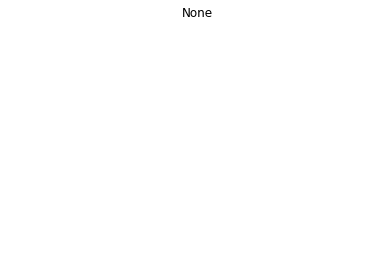

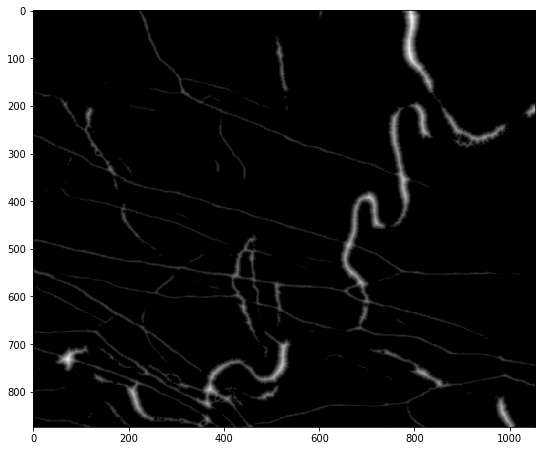

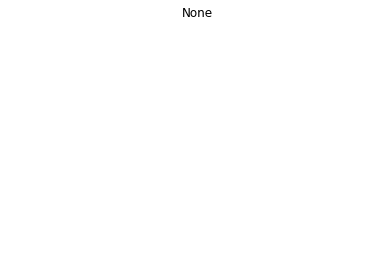

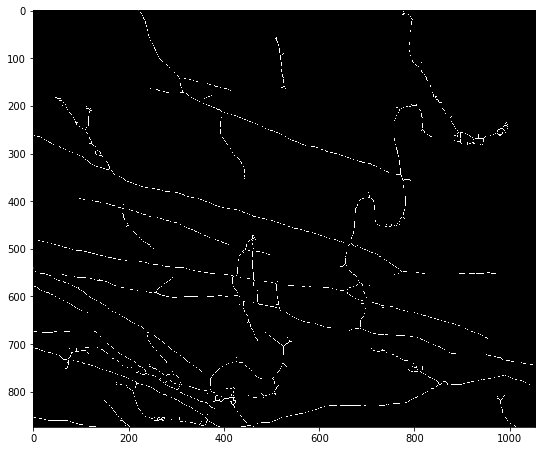

(874, 1054)


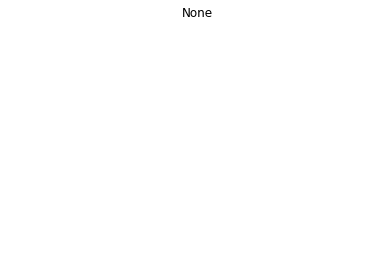

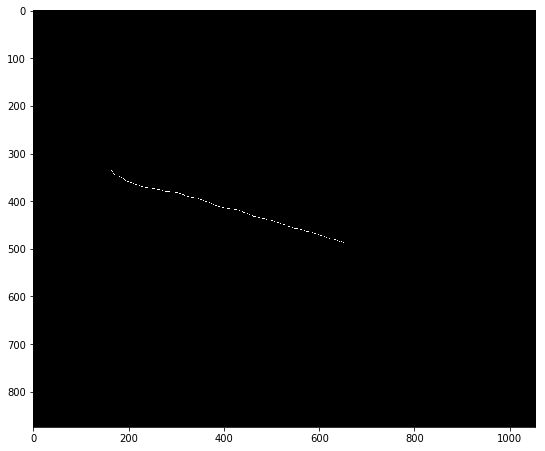

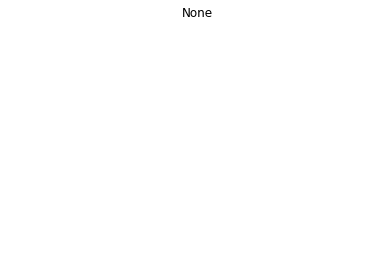

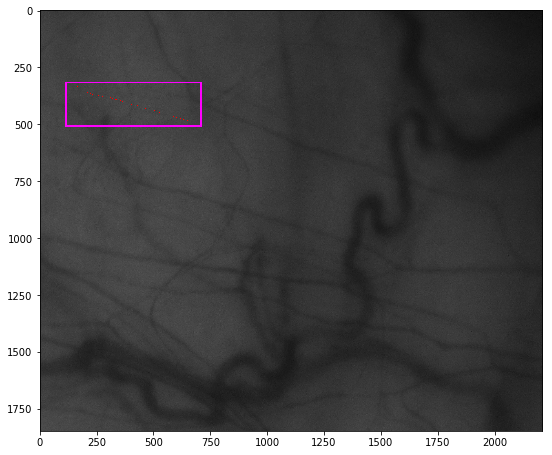

(192, 593, 3)


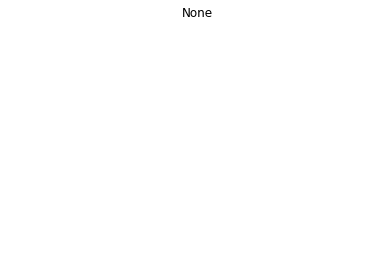

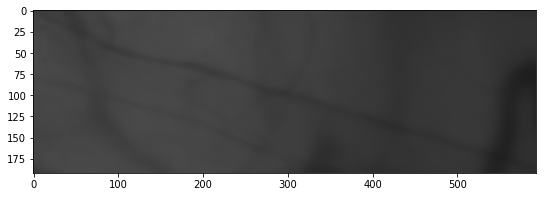

In [5]:
'''
Generate template image utilize vessel morphological features

INPUT : segmentation vessel imgs (SEG_MAP_PATH)
OUTPUT : Labeled centerline imgs, Sorted template vessels images

'''
# Hyperparam
thr_val = 20
template_top_k = 1

# Init
first_centerline_imgs = np.zeros((SHAPE_IMGS[0], SHAPE_IMGS[1]))
first_dist_map = np.zeros((SHAPE_IMGS[0], SHAPE_IMGS[1]))

# Processing
cur_centerline_imgs = centerline_extraction(SEG_VESSEL_IMGS[0])
post_proc_centerline_imgs = post_processing_skelImg(cur_centerline_imgs, connectivity_thr=thr_val)
branched_centerline = branches(post_proc_centerline_imgs)
branched_centerline_points = extract_branch_cordi(branched_centerline)
branched_centerline_circles = draw_circle_branch_points_on_skelImg(post_proc_centerline_imgs, branched_centerline_points)
removed_branch_imgs = remove_branch_points(post_proc_centerline_imgs, branched_centerline)
removed_branch_imgs = np.array(removed_branch_imgs,np.uint8)
num_each_vessel_label, labeled_vessel_map = cv2.connectedComponents(removed_branch_imgs)

first_centerline_imgs = labeled_vessel_map
num_each_vessel_label = int(np.array(num_each_vessel_label,np.uint16))
first_dist_map = 2* distance_transform_edt(SEG_VESSEL_IMGS[0])


# Output
topK_vessel_map, template_cord, sorted_len_vessels,no_norm_len_info  = generating_template_imgs(first_centerline_imgs,
                                                                                                first_dist_map,
                                                                               num_each_vessel_label,SHAPE_IMGS, 
                                                                               top_k = 5,a = 0.5, b= 0.5)
row, col = np.where(topK_vessel_map == template_top_k)
template_img = ORI_VESSEL_IMGS[0]
template_img = template_img[template_cord[template_top_k-1,1] : template_cord[template_top_k-1,3],
                            template_cord[template_top_k-1,0] : template_cord[template_top_k-1,2],:]
print(np.shape(template_img))


if debug_flag ==True:
    temp_flag = False
    for count, filename in enumerate(sorted(os.listdir(ORI_MAP_PATH)), start=0):
        if filename.startswith(".ipynb") == False:
            if temp_flag == False:
                debug_ori_map =cv2.imread(ORI_MAP_PATH +filename)
            else :
                break
            
    cv2.rectangle(debug_ori_map, (template_cord[template_top_k-1][0], template_cord[template_top_k-1][1]) ,
                  (template_cord[template_top_k-1][2], template_cord[template_top_k-1][3]),
                  (255,0,255), 5 ) #left top right bottom == xmin ymin xmax ymax
    help_functions.show_on_jupyter(first_dist_map,'gray')
    help_functions.show_on_jupyter(post_proc_centerline_imgs,'gray')
    cv2.imwrite('./diameter.png',first_dist_map)
    print(np.shape(post_proc_centerline_imgs))
    temp_skel = np.asarray(np.expand_dims(post_proc_centerline_imgs,-1) * 255, dtype=np.uint8)
    cv2.imwrite('./skeleton.png',temp_skel)
    
    temp = np.zeros((SHAPE_IMGS[0], SHAPE_IMGS[1]), dtype= np.uint8)
    row, col = np.where(topK_vessel_map == template_top_k)
    temp[row,col] = 255
    
    
    help_functions.show_on_jupyter(temp, 'gray')
    debug_ori_map[row,col] = (0,0,255)
    help_functions.show_on_jupyter(debug_ori_map)
    
    print(np.shape(template_img))
    help_functions.show_on_jupyter(template_img)
    
template_img = template_img[:,:,1]


#### 5. Motion compensation using template matching
- Input : Sorted template vessels images (Best template), Each conj raw frames
- Description : Template maching and motion compensation
- 5.1. Template matching each frames
    - Input : Sorted template vessels images (Best template), Each conj raw frames
    - Description : Do template matching algoritm and get results from each frames
    - Output : Each frame tempate matching results coordinates (Center coordinates)
- 5.2. Motion compensation using template matching coordinates
    - Input : Each frame tempate matching results coordinates, Each conj raw frames
    - Description : Motion compensation each frame based on first template matching results
    - Output : Motion compensated frames
- Output : Motion compensated frames

In [6]:
def template_matching_each_imgs(ori_imgs, template_img, num_img, save_folder = None, debug_flag = False):
    
    img = (ori_imgs[0].astype(np.float32))[:,:,1]
    img2 = img.copy()
    template = template_img.astype(np.float32)
    w, h = np.shape(template_img)[1], np.shape(template_img)[0]

    # All the 6 methods for comparison in a list
    methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
                'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
    method = eval('cv2.TM_CCOEFF_NORMED')
    
    #for meth in methods:

    template_result_coord = np.zeros((num_img, 4), dtype=np.uint16)
    
    if save_folder != None:
        help_functions.dir_checker(save_folder)
    for idx in range(num_img):
        debug_img = ori_imgs[idx].copy()
        img = (ori_imgs[idx].astype(np.float32))[:,:,1]
        #print(np.shape(img))
        #print(type(img[0,0]))
        # Apply template Matching
        res = cv2.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)

        crop_result = img[top_left[1] : bottom_right[1],top_left[0] : bottom_right[0]]
        
        # yolo format xmin ymin xmax ymax
        template_result_coord[idx, 0] = top_left[0]
        template_result_coord[idx, 1] = top_left[1]
        template_result_coord[idx, 2] = bottom_right[0]
        template_result_coord[idx, 3] = bottom_right[1]
        
        print('xmin {} ymin {} xmax {} ymax {}'.format(top_left[0], top_left[1], bottom_right[0], bottom_right[1]))
        
        if debug_flag == True:
            cv2.imwrite(save_folder+'original_'+str(idx)+'_.png', img)
            cv2.imwrite(save_folder+'crop_result_'+str(idx)+'_.png', crop_result)
            cv2.rectangle(debug_img,top_left, bottom_right, 255, 2)
            cv2.imwrite(save_folder+'SQDIFF__NORMED_original_rec_'+str(idx)+'_.png',debug_img)
            
    return template_result_coord

def motion_compensation_template_shift(ori_imgs,template_coord, ref_template_coord, num_img, shape_img, save_folder = None,debug_flag = False):
    print('ref template cood, xmin : {} ymin : {} xmax : {}  ymax : {}'.format(ref_template_coord[0],ref_template_coord[1],
                                                                              ref_template_coord[2], ref_template_coord[3]))
    compensated_imgs = np.zeros((num_img, shape_img[0], shape_img[1]), dtype=np.float32)
    diff_x_lists = []
    diff_y_lists = []
    
    ref_center_x, ref_center_y = int((ref_template_coord[0] + ref_template_coord[2])/2 ),int((ref_template_coord[1] + ref_template_coord[3])/2 )
    if save_folder != None:
        save_folder = save_folder + 'compensated/'
        help_functions.dir_checker(save_folder)
        
        
    if debug_flag == True:
        h,w = shape_img[0], shape_img[1]
        print('[debug] h : ',h,' w : ',w)
        fps =20
        out = cv2.VideoWriter('compensated_conj.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, (w,h))

    for idx in range(1, num_img):
        one_ch_ori_imgs = ori_imgs[idx, :,:,1].copy()
        
        
        center_x, center_y = int((template_coord[idx][0] + template_coord[idx][2])/2 ), int((template_coord[idx][1] + template_coord[idx][3])/2 )
        diff_x, diff_y = ref_center_x - center_x, ref_center_y - center_y
        diff_x_lists.append(diff_x); diff_y_lists.append(diff_y)
        print('diff x : {} diff y : {}'.format(diff_x, diff_y))
        shift_array = np.float32([[1,0,diff_x],[0,1,diff_y]])
        dst = cv2.warpAffine(one_ch_ori_imgs, shift_array,(shape_img[1], shape_img[0]))
        
        compensated_imgs[idx] = dst
        
        if debug_flag == True:
            
            out.write(compensated_imgs[idx].astype(np.uint8))
            
            if idx >= 10:
                cv2.imwrite(save_folder+'compensated_'+str(idx)+'_.png', dst)
            else:
                cv2.imwrite(save_folder+'compensated_0'+str(idx)+'_.png', dst)
                
        out.release()
    return compensated_imgs, diff_x_lists, diff_y_lists


In [7]:
# hyperparam
template_save_folder = './template_result/'
bias_compensate_crop = 5

# Input and processing
template_result_coord = template_matching_each_imgs(ORI_VESSEL_IMGS, template_img, NUM_ORI_IMGS,
                                                    template_save_folder, debug_flag=debug_flag)

compensated_ori_imgs, diff_x_lists, diff_y_lists = motion_compensation_template_shift(ORI_VESSEL_IMGS, template_result_coord,template_cord[template_top_k-1], 
                                                          NUM_ORI_IMGS, SHAPE_IMGS, 
                                                         template_save_folder, debug_flag = True)

max_diff_y = max(diff_x_lists)
max_diff_x = max(diff_y_lists)
crop_compensated_ori_imgs = np.zeros((NUM_ORI_IMGS, np.shape(compensated_ori_imgs)[1]-2*(bias_compensate_crop)-2*(max_diff_y), np.shape(compensated_ori_imgs)[2]-2*(bias_compensate_crop)-2*(max_diff_x) ))
crop_label_vessel_maps = labeled_vessel_map[bias_compensate_crop  + max_diff_y : -(bias_compensate_crop + max_diff_y), bias_compensate_crop  + max_diff_x: -(bias_compensate_crop + max_diff_x)]
crop_shape = (np.shape(crop_compensated_ori_imgs)[1], np.shape(crop_compensated_ori_imgs)[2])


print('before compensated ori shape : ', np.shape(compensated_ori_imgs))
for idx in range(np.shape(compensated_ori_imgs)[0]):
    crop_compensated_ori_imgs[idx] = compensated_ori_imgs[idx, bias_compensate_crop  + max_diff_y : -(bias_compensate_crop + max_diff_y), bias_compensate_crop  + max_diff_x: -(bias_compensate_crop + max_diff_x) ]
    
print('after compensated ori shape : ', np.shape(crop_compensated_ori_imgs))

already exist the folder in this path : ./template_result/
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 112 ymin 319 xmax 705 ymax 511
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 113 ymin 317 xmax 706 ymax 509
xmin 

#### 6. Flowable vessel proposal based on temporal variance filtering and vessel length
- Input : Motion compensated frames, vessel centerline info(4.1), each vessels length infomations (4.3)
- Description : Get temporal variance (Intensity from frames) and Do proposal algorithm additionly vessel lengths
- 6.1. Labeling from ref segmap 
    - Input : 
    - Description : 
    - Output : labeld coded img
- 6.2. Temporal variance filtering 
    - Input : compensated imgs, labeled img (for coord)
    - Description : usning each vessel coordinates (labeled img) sampling from compensated imgs
                    then, cacualte frame-wise mean and variance
                    finally, do temporal variance filtering. 
    - Output : filter passed vessel sorted by index
- 6.3. Get information (sorted from length)
    - Input : Sorted template vessels images (Best template), Each conj raw frames
    - Description : Based on labeled imgs, get the information 'length' from reference img (first img)
                    and 'temporal variance' from frame-wise sampling (except zero value)              
    - Output : Each frame tempate matching results coordinates (Center coordinates)
- 6.4. flowable vessel proposal, top_k
    - Input : centerline labeled img, length info, temporal variance info
    - Description : Motion compensation each frame based on first template matching results
    - Output : Motion compensated frames  

In [8]:
#def labeling_ref_segmap(ref_img):

def temporal_vessel_filtering(compensated_imgs, label_img, num_img, num_label, shape_img,outlier_thr = 20):
    '''
    1. get centerline coord
    2. each centerline, get intensity value
    3. get std
    '''
    before_filter_passed_vessel_idx = []
    filter_passed_vessel_idx = []
    mean_vessel_std = 0
    
    cnt = 0
    for label_idx in range(1,num_label):
        # centerline coord
        row,col = np.where(label_img == label_idx)
        
        pixel_wise_vessel_var = np.zeros((num_img,len(row)),dtype=np.float32) #frame x each pixel
        

        
        for idx in range(num_img):
            # sampling     
            pixel_wise_vessel_var[idx] = compensated_imgs[idx,row, col] 
            
        frame_wise_vessel_std = np.std(pixel_wise_vessel_var, axis = 1)
        before_filter_passed_vessel_idx.append((np.mean(frame_wise_vessel_std, dtype=np.float16), label_idx))
        mean_vessel_std = mean_vessel_std + np.mean(frame_wise_vessel_std)
        cnt = cnt +1
    
    mean_vessel_std = mean_vessel_std / cnt
    
    for idx in range(len(before_filter_passed_vessel_idx)):
        if (before_filter_passed_vessel_idx[idx][0] > mean_vessel_std) and (before_filter_passed_vessel_idx[idx][0] <outlier_thr ):
            #print(before_filter_passed_vessel_idx[idx][0])
            filter_passed_vessel_idx.append(before_filter_passed_vessel_idx[idx])
        else:
            pass        
        
    return filter_passed_vessel_idx, mean_vessel_std, before_filter_passed_vessel_idx
    
def flowable_vessel_proposal(length_info, tem_var_info,a = 0.8,b = 0.2,top_k =20):
    '''
    1. norm length (each vessel)
    2. norm temporal variance (each vessel)
    3. proposal equation
    0.7 * temporal variance + 0.3 * length, sorting
    '''
    #print(length_info[0])
    #print(length_info[0][0],length_info[0][1])
    
    num_var_info = len(tem_var_info)
    norm_var_info = [] 
    sorted_var_info = sorted(tem_var_info, reverse=True)
    print('sorted var info : ', sorted_var_info)
    max_var_value = sorted_var_info[0][0]
    min_var_value = sorted_var_info[-1][0]
    
    for idx in range(num_var_info):
        norm_var_info.append(((sorted_var_info[idx][0] - min_var_value ) / (max_var_value-min_var_value),sorted_var_info[idx][1]))
    
    proposed_vessel = []
    print('\n norm val : \n',norm_var_info)
    for var_idx in range(num_var_info):
        each_norm_var_value = norm_var_info[var_idx][0]
        each_norm_var_vessel_idx = norm_var_info[var_idx][1]
        
        #print(len(length_info))
        
        for len_idx in range(len(length_info)):
            #print(length_info[len_idx][1], ' ',each_norm_var_vessel_idx )
            if length_info[len_idx][1] == each_norm_var_vessel_idx:
                each_vessel_len_value = length_info[len_idx][0]
                each_vessel_len_ids = length_info[len_idx][1]
                #print('var idx : {} len idx : {}'.format(each_norm_var_vessel_idx,length_info[len_idx][1]))
                
        print('norm var value : {} norm len value : {}'.format(each_norm_var_vessel_idx, each_vessel_len_value))
        proposal_eq = (a* each_norm_var_value) + (b* each_vessel_len_value)
        proposed_vessel.append((proposal_eq, each_norm_var_vessel_idx))
    
    proposed_vessel = sorted(proposed_vessel, reverse=True)
    
    return proposed_vessel[0:top_k],sorted_var_info

(874, 1054)
(874, 1054, 3)


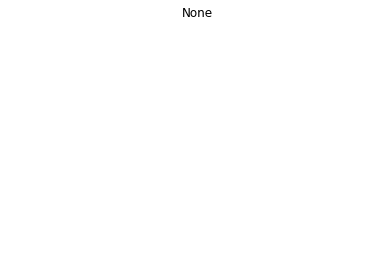

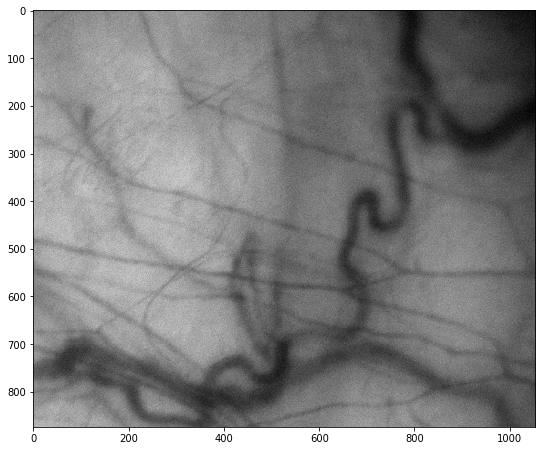

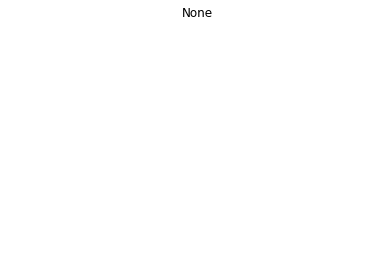

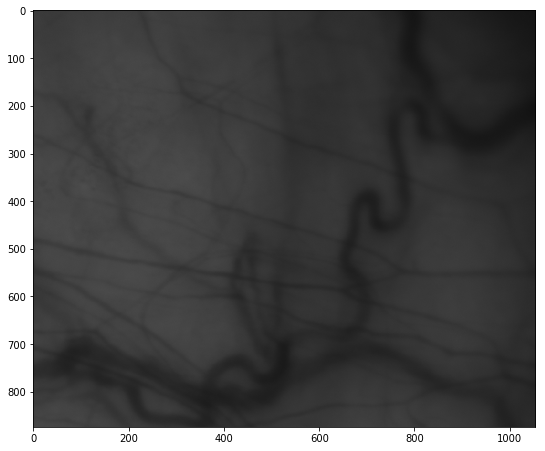

In [9]:
print(np.shape(compensated_ori_imgs[0]))
print(np.shape(ORI_VESSEL_IMGS[0]))

help_functions.show_on_jupyter(compensated_ori_imgs[1],'gray')
help_functions.show_on_jupyter(ORI_VESSEL_IMGS[0,:,:,0])

filter passed :  [(3.992, 1), (3.076, 2), (1.906, 9), (1.721, 10), (1.655, 11), (1.971, 12), (1.768, 14), (1.74, 16), (1.886, 18), (1.848, 20), (1.955, 21), (2.125, 22), (3.562, 25), (1.897, 26), (2.215, 27), (1.637, 31), (1.606, 36), (4.95, 38), (1.605, 41), (2.08, 42), (1.795, 43), (1.702, 46), (1.811, 48), (1.793, 50), (1.851, 53), (1.605, 57), (1.915, 58), (2.117, 59), (1.585, 61), (2.314, 62), (1.664, 65), (1.91, 69), (2.412, 79), (1.616, 80), (2.125, 83), (3.008, 91), (1.539, 95), (1.887, 112), (1.988, 116), (1.819, 117), (1.899, 118), (6.36, 119), (2.852, 120), (2.986, 122), (2.475, 123), (2.602, 124), (2.178, 125), (1.624, 126), (2.834, 127), (1.753, 128), (3.691, 129), (2.055, 130), (2.268, 141), (1.649, 145), (5.016, 146), (2.174, 149), (1.61, 150), (2.773, 152), (1.545, 156), (2.324, 157), (1.603, 158), (1.551, 160), (2.305, 162), (2.934, 163), (1.566, 166), (2.4, 167), (2.008, 168), (1.69, 169), (4.316, 170), (2.783, 171), (1.595, 172), (2.496, 173), (2.682, 174), (1.837, 1

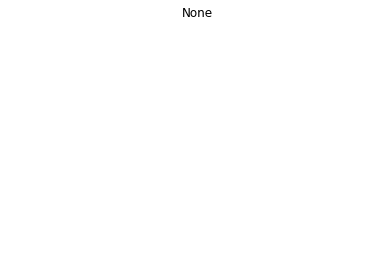

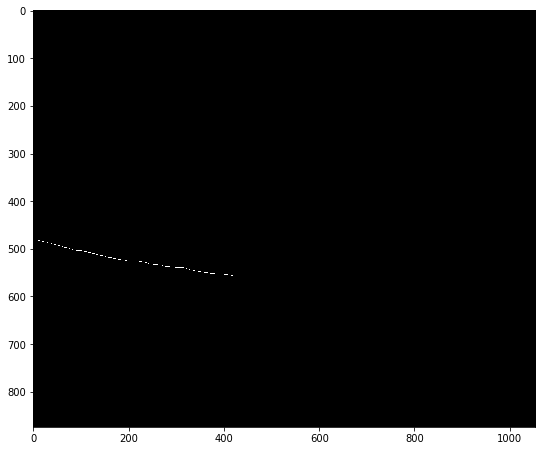

6.399467177500298
(874, 1054, 3)


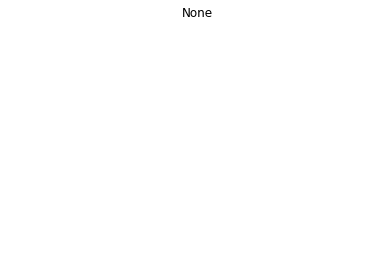

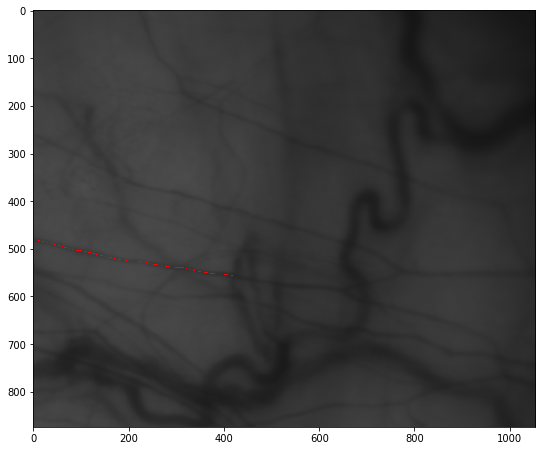

In [10]:
# Hyperparam
OUTLIER_THR = 20
# Input

# Processingㅊ

filter_passed_vessel_idx, mean_vessel_std, before_filter_vessel_idx = temporal_vessel_filtering(compensated_ori_imgs, 
                                                                                    labeled_vessel_map, NUM_ORI_IMGS,
                                                                                    num_each_vessel_label, SHAPE_IMGS,
                                                                                               outlier_thr = OUTLIER_THR )
'''
filter_passed_vessel_idx, mean_vessel_std, before_filter_vessel_idx = temporal_vessel_filtering(ORI_VESSEL_IMGS[:,:,:,0], 
                                                                                    labeled_vessel_map, NUM_ORI_IMGS,
                                                                                    num_each_vessel_label, SHAPE_IMGS,
                                                                                               outlier_thr = OUTLIER_THR )

'''
print('filter passed : ', filter_passed_vessel_idx)
proposed_vessel,sorted_var_info = flowable_vessel_proposal(sorted_len_vessels, filter_passed_vessel_idx, a =0.2, b=0.8, top_k=20)


if debug_flag ==True:
    temp = np.zeros((SHAPE_IMGS[0], SHAPE_IMGS[1]), dtype= np.uint8)
    row, col = np.where(labeled_vessel_map == proposed_vessel[1][1])
    temp[row,col] = 255
    help_functions.show_on_jupyter(temp, 'gray')
    
    temp_proposed_vessel_dist = first_dist_map[row,col]
    print(np.mean(temp_proposed_vessel_dist ))
    
    temp2 = ORI_VESSEL_IMGS[0].copy()
    print(np.shape(temp2))
    temp2[row, col,:] = (0,0,255)
    help_functions.show_on_jupyter(temp2)
    cv2.imwrite('top_1_img.png',temp2)
    
    

In [11]:
filter_passed_vessel_idx

[(3.992, 1),
 (3.076, 2),
 (1.906, 9),
 (1.721, 10),
 (1.655, 11),
 (1.971, 12),
 (1.768, 14),
 (1.74, 16),
 (1.886, 18),
 (1.848, 20),
 (1.955, 21),
 (2.125, 22),
 (3.562, 25),
 (1.897, 26),
 (2.215, 27),
 (1.637, 31),
 (1.606, 36),
 (4.95, 38),
 (1.605, 41),
 (2.08, 42),
 (1.795, 43),
 (1.702, 46),
 (1.811, 48),
 (1.793, 50),
 (1.851, 53),
 (1.605, 57),
 (1.915, 58),
 (2.117, 59),
 (1.585, 61),
 (2.314, 62),
 (1.664, 65),
 (1.91, 69),
 (2.412, 79),
 (1.616, 80),
 (2.125, 83),
 (3.008, 91),
 (1.539, 95),
 (1.887, 112),
 (1.988, 116),
 (1.819, 117),
 (1.899, 118),
 (6.36, 119),
 (2.852, 120),
 (2.986, 122),
 (2.475, 123),
 (2.602, 124),
 (2.178, 125),
 (1.624, 126),
 (2.834, 127),
 (1.753, 128),
 (3.691, 129),
 (2.055, 130),
 (2.268, 141),
 (1.649, 145),
 (5.016, 146),
 (2.174, 149),
 (1.61, 150),
 (2.773, 152),
 (1.545, 156),
 (2.324, 157),
 (1.603, 158),
 (1.551, 160),
 (2.305, 162),
 (2.934, 163),
 (1.566, 166),
 (2.4, 167),
 (2.008, 168),
 (1.69, 169),
 (4.316, 170),
 (2.783, 171),

## len(before_filter_vessel_idx)

already exist the folder in this path : ./data/201130/


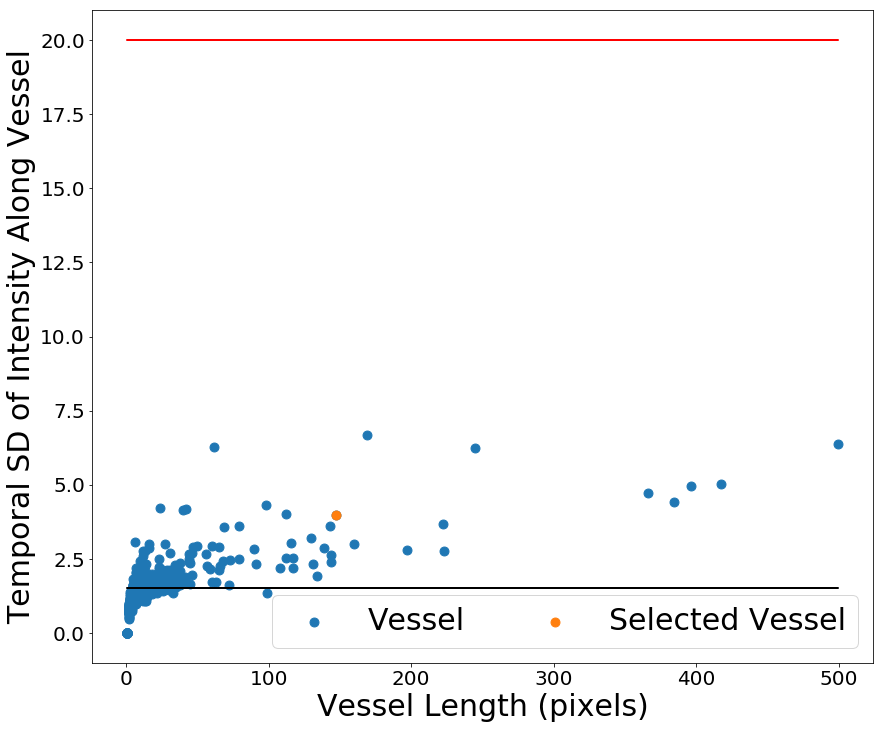

In [12]:
len_lists = []
tem_var_lists = []
highlight_proposed_var_lists = []
highlight_proposed_len_lists = []
for var_idx in range(len(before_filter_vessel_idx)):
    tem_var_value = before_filter_vessel_idx[var_idx][0]
    tem_var_idx = before_filter_vessel_idx[var_idx][1]
    for len_idx in range(len(no_norm_len_info)):
        if no_norm_len_info[len_idx][1] == tem_var_idx:
            len_lists.append(no_norm_len_info[len_idx][0])
            tem_var_lists.append(tem_var_value)

for var_idx in range(len(before_filter_vessel_idx)):
    _var_value = before_filter_vessel_idx[var_idx][0]
    _var_idx = before_filter_vessel_idx[var_idx][1]
    for idx in range(len(proposed_vessel)):
        prop_var_value = proposed_vessel[idx][0]
        prop_var_idx = proposed_vessel[idx][1]
        if prop_var_idx == _var_idx:
            for len_idx in range(len(no_norm_len_info)):
            #for len_idx in range(len(n)):
                if no_norm_len_info[len_idx][1] == prop_var_idx:
                    highlight_proposed_len_lists.append(no_norm_len_info[len_idx][0])
                    highlight_proposed_var_lists.append(_var_value)
                    

plt.figure(figsize = (14,12))
l = plt.scatter(len_lists, tem_var_lists, s = 80)
mean_lists = []
out_lier_thr = OUTLIER_THR
out_lists = []

for idx in range(len(no_norm_len_info)):
    mean_lists.append(mean_vessel_std)
    out_lists.append(out_lier_thr)

plt.xlabel('Vessel Length (pixels)', fontsize = 30)
plt.ylabel('Temporal SD of Intensity Along Vessel', fontsize = 30)

plt.plot(len_lists,mean_lists ,'black')
plt.plot(len_lists, out_lists, 'red')
lo = plt.scatter(highlight_proposed_len_lists[0], highlight_proposed_var_lists[0],s = 80)

plt.legend((l,lo),
           ('Vessel', 'Selected Vessel'),
           scatterpoints=1,
           ncol=2,
           fontsize=30)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)

fig_save_folder = './data/201130/'
help_functions.dir_checker(fig_save_folder)
plt.savefig(fig_save_folder+'fig1.png', dpi=700)

plt.show()




#### 7. Spatial Temporal Analysis
- Input : sorted flowable vessels and coordinates
- Description : DO STA algorithm
- Output : genterat STA images each frames based on vessel informations

In [13]:
import pandas as pd
def spatial_temporal_analysis(compensated_img, label_img, proposed_vessel_idx,debug_flag = False, save_folder = None): 
    if debug_flag == True:
        help_functions.dir_checker(save_folder)
        
    sta_table = pd.DataFrame(columns=['Top_K','Vessel length (px)','Vessel length (mm)','Vessel distance (px)','Vessel distance (mm)','Variance','Eq value','Number of frames'])
    top_k = len(proposed_vessel_idx)
    sta_lists = []
        
    for idx in range(top_k): # top-k
        row,col = np.where(label_img == proposed_vessel_idx[idx][1])
        sta_array = np.zeros(len(row),dtype=np.uint8)
        for img_idx in range(np.shape(compensated_img)[0]):
            flatten_img = compensated_img[img_idx][row,col]
            #print('flatten shape : ', np.shape(flatten_img))
            sta_array = np.vstack((sta_array,flatten_img))
            #print('each sta shape : ', np.shape(sta_array))

        
        sta_array = sta_array[1:,:]
        sta_array = sta_array.transpose(1,0)
        print('shape of sta array : ', np.shape(sta_array))
        sta_lists.append(sta_array)
        
        print('debug flag : ', debug_flag)
        if debug_flag == True:
            print('idx : ', idx)
            if idx < 10:
                cv2.imwrite(save_folder+'0'+str(idx)+'.png',sta_array)
                pixel_len, fps = np.shape(sta_array)
                sta_table.loc[idx,'Top_K' ] = '0'+str(idx)
                pixel_06_len = float("{0:.6f}".format(float(pixel_len)))
                sta_table.loc[idx,'Vessel length (px)' ] = pixel_06_len
                mm_len = float("{0:.6f}".format(float(pixel_len / 550)))
                sta_table.loc[idx,'Vessel length (mm)' ] = mm_len
                sta_table.loc[idx,'Number of frames' ] = fps
                    
            else:
                cv2.imwrite(save_folder+str(idx)+'.png',sta_array)
                pixel_len, fps = np.shape(sta_array)
                sta_table.loc[idx,'Top_K' ] = str(idx)
                pixel_06_len = float("{0:.6f}".format(float(pixel_len)))
                sta_table.loc[idx,'Vessel length (px)' ] = pixel_06_len
                mm_len = float("{0:.6f}".format(float(pixel_len / 550)))
                sta_table.loc[idx,'Vessel length (mm)' ] = mm_len
                sta_table.loc[idx,'Number of frames' ] = fps
                
            #sta_table.to_excel(save_folder + "sta_table.xlsx")  
            #sta_table.to_csv(save_folder + "sta_table.csv")  
                
                
    return sta_lists,sta_table
                
            #temp = np.zeros((SHAPE_IMGS[0], SHAPE_IMGS[1]), dtype= np.uint8)
            #row, col = np.where(labeled_vessel_map == proposed_vessel[0][1])
            #temp[row,col] = 255
            #help_functions.show_on_jupyter(temp, 'gray')


In [14]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)


def df(img):  # to make a histogram (count distribution frequency)
    values = [0]*256
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            values[img[i,j]]+=1
    return values


def cdf(hist):  # cumulative distribution frequency
    cdf = [0] * len(hist)   #len(hist) is 256
    cdf[0] = hist[0]
    for i in range(1, len(hist)):
        cdf[i]= cdf[i-1]+hist[i]
    # Now we normalize the histogram
    cdf = [ele*255/cdf[-1] for ele in cdf]      # What your function h was doing before
    return cdf

def equalize_image(image):
    my_cdf = cdf(df(image))
    # use linear interpolation of cdf to find new pixel values. Scipy alternative exists
    import numpy as np
    image_equalized = np.interp(image, range(0,256), my_cdf)
    return image_equalized



already exist the folder in this path : ./pipe_result/temp/
already exist the folder in this path : ./pipe_result/temp/sta_result/
already exist the folder in this path : ./pipe_result/temp/sta_result/histogram_equal/
already exist the folder in this path : ./pipe_result/temp/sta_result/clahe/
already exist the folder in this path : ./pipe_result/temp/sta_result/
shape of sta array :  (499, 36)
debug flag :  True
idx :  0
shape of sta array :  (417, 36)
debug flag :  True
idx :  1
shape of sta array :  (396, 36)
debug flag :  True
idx :  2
shape of sta array :  (384, 36)
debug flag :  True
idx :  3
shape of sta array :  (366, 36)
debug flag :  True
idx :  4
shape of sta array :  (245, 36)
debug flag :  True
idx :  5
shape of sta array :  (169, 36)
debug flag :  True
idx :  6
shape of sta array :  (222, 36)
debug flag :  True
idx :  7
shape of sta array :  (223, 36)
debug flag :  True
idx :  8
shape of sta array :  (197, 36)
debug flag :  True
idx :  9
shape of sta array :  (147, 36)
de

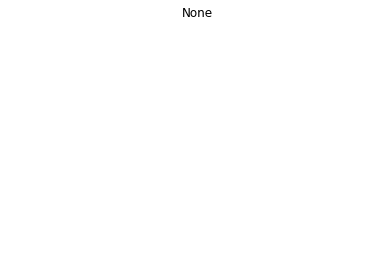

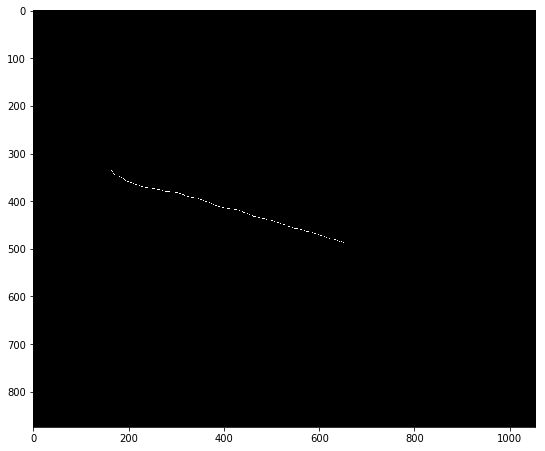

(874, 1054, 3)


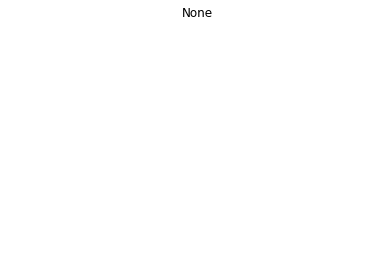

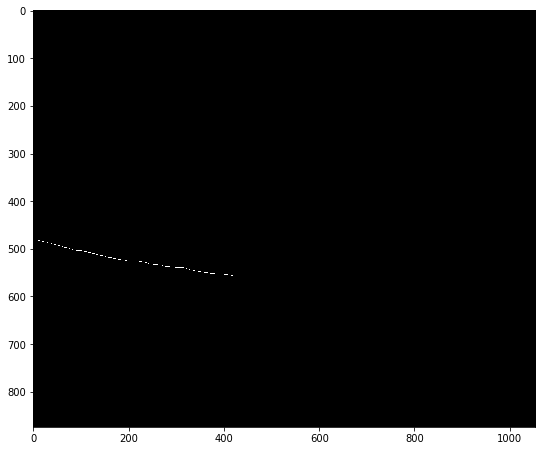

(874, 1054, 3)


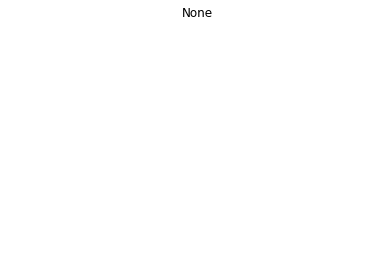

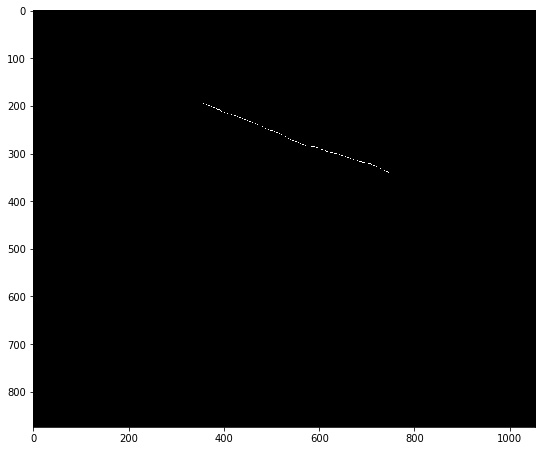

(874, 1054, 3)


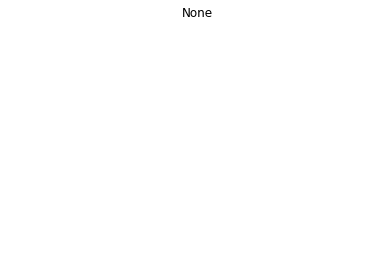

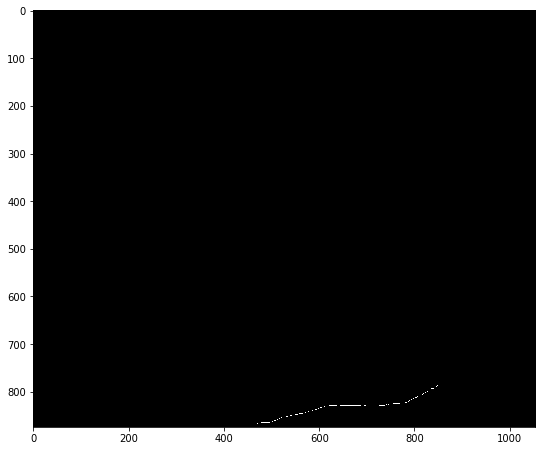

(874, 1054, 3)


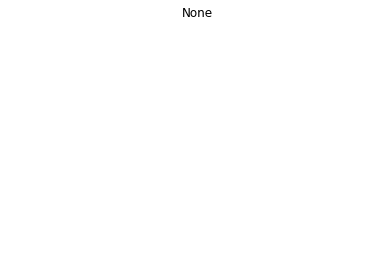

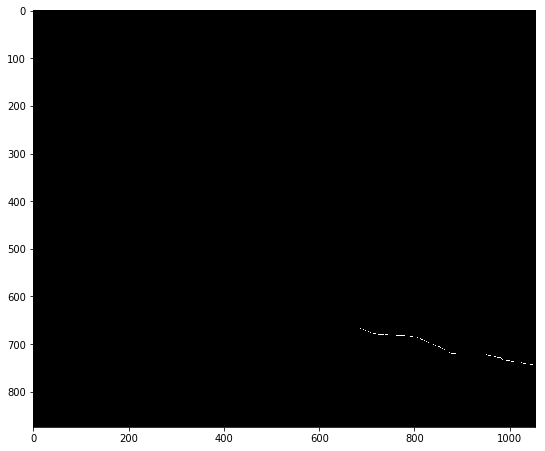

(874, 1054, 3)


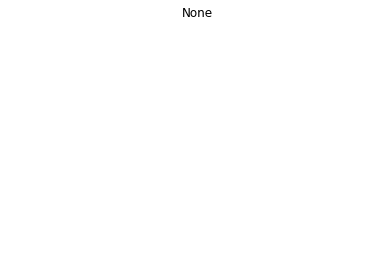

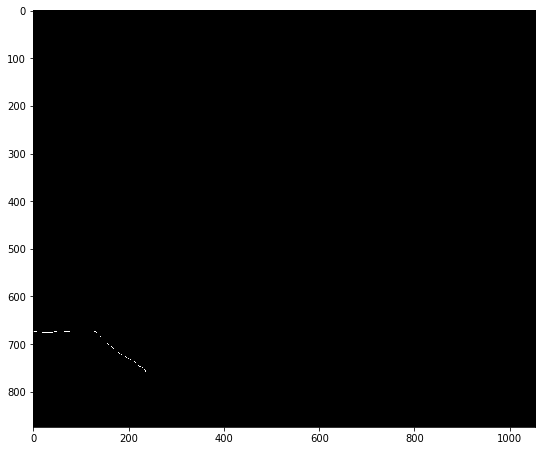

(874, 1054, 3)


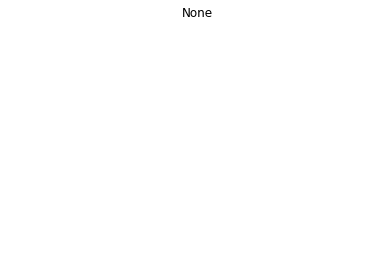

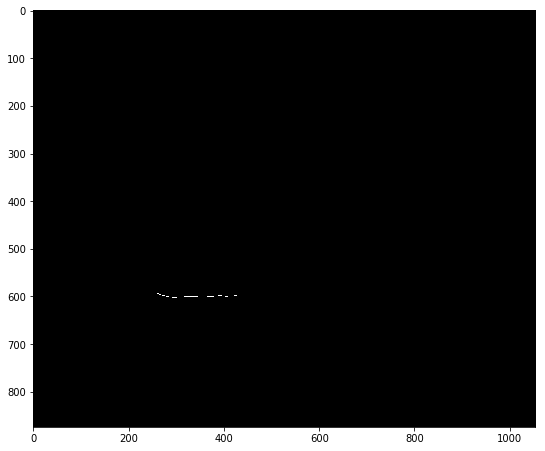

(874, 1054, 3)


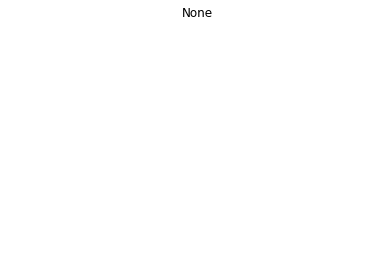

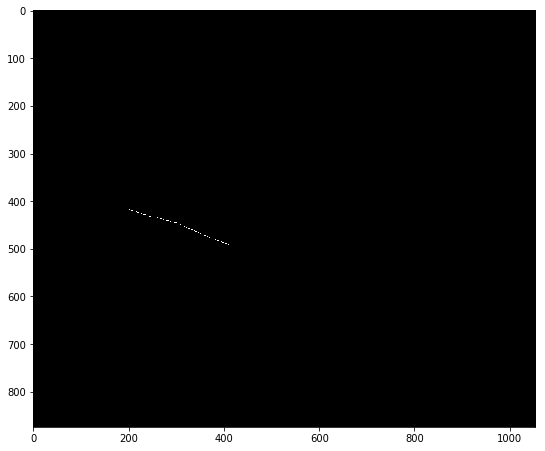

(874, 1054, 3)


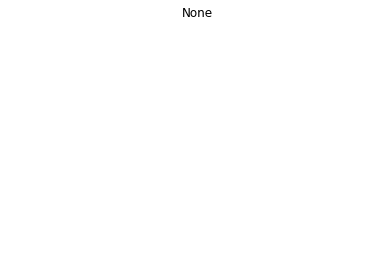

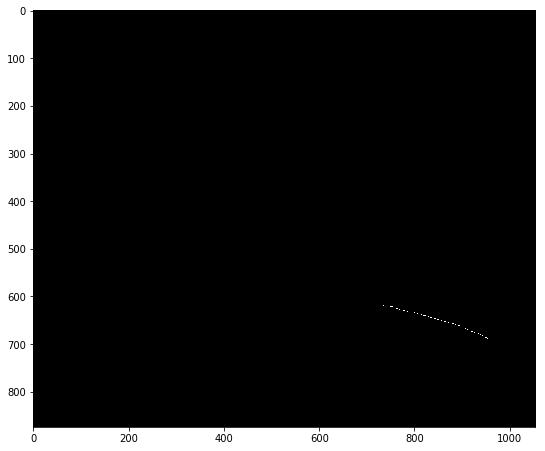

(874, 1054, 3)


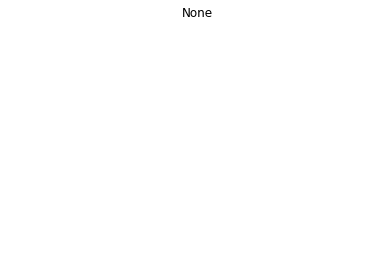

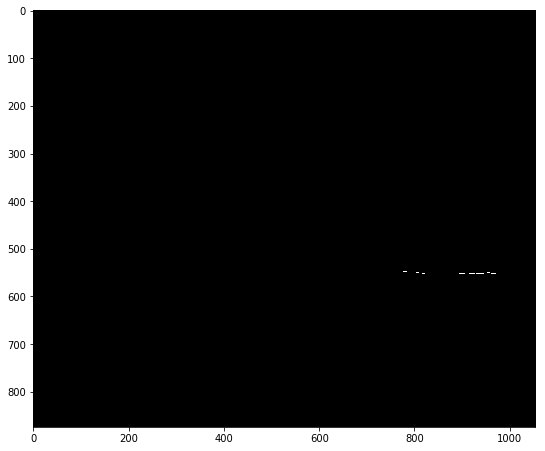

(874, 1054, 3)


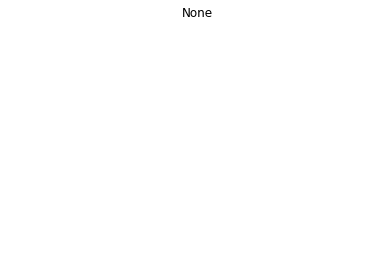

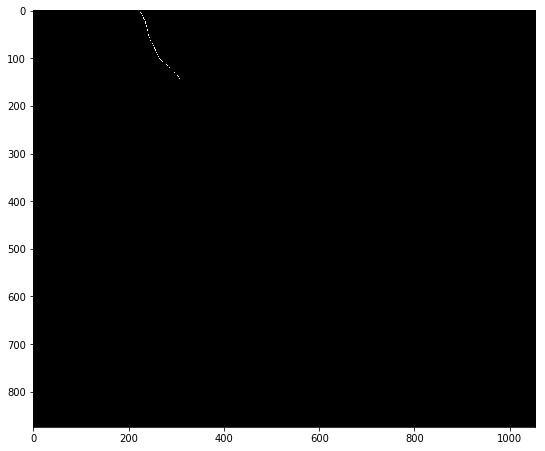

(874, 1054, 3)


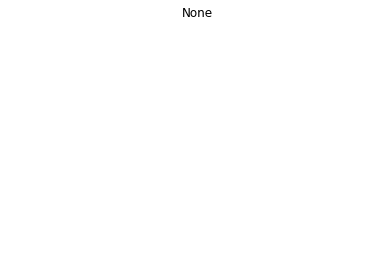

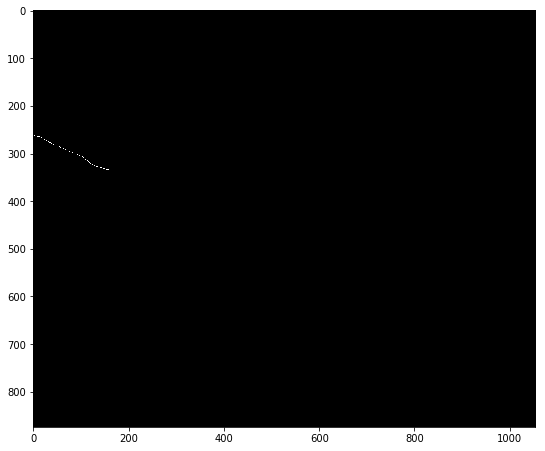

(874, 1054, 3)


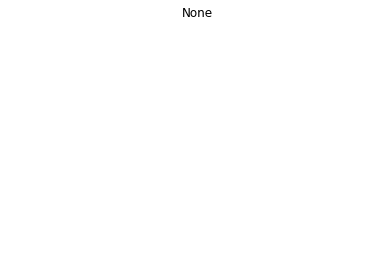

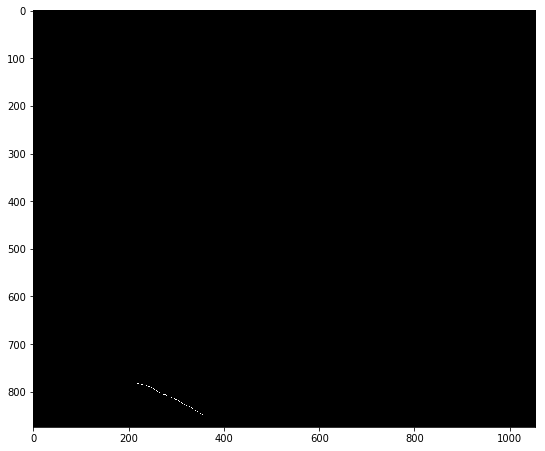

(874, 1054, 3)


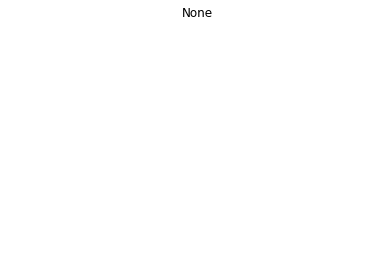

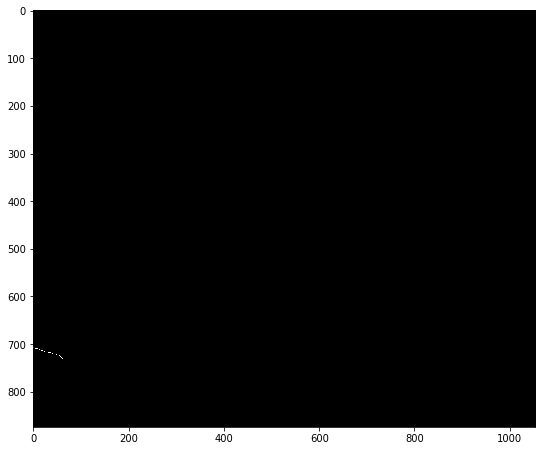

(874, 1054, 3)


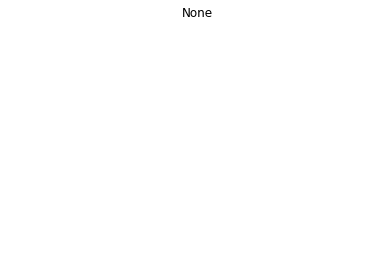

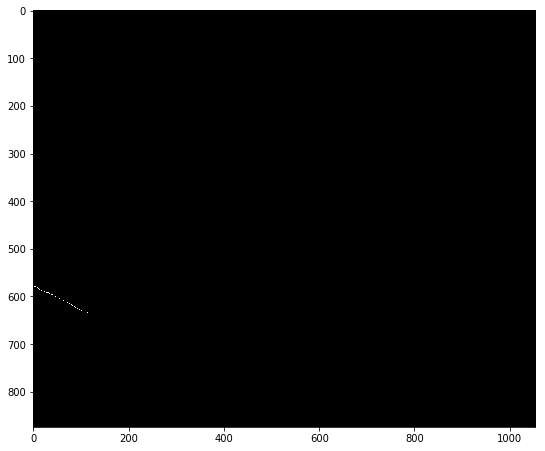

(874, 1054, 3)


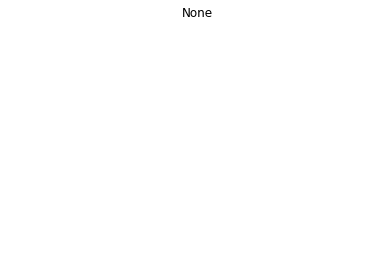

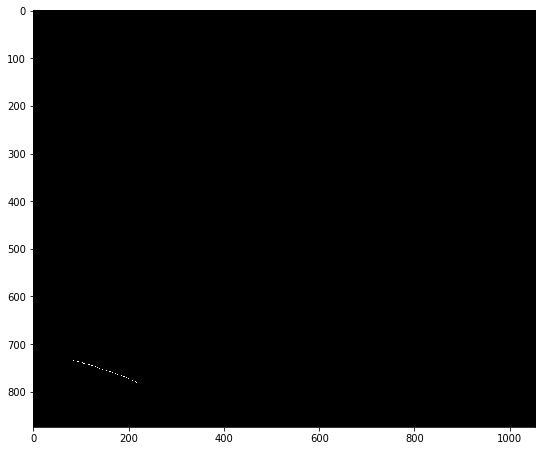

(874, 1054, 3)


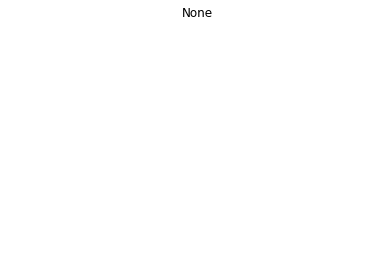

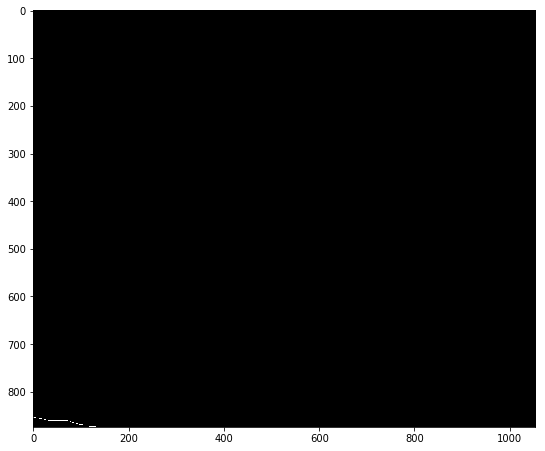

(874, 1054, 3)


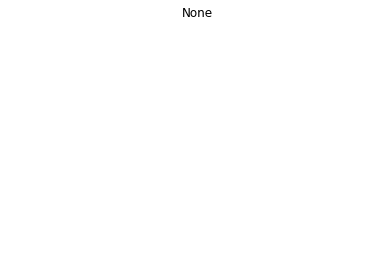

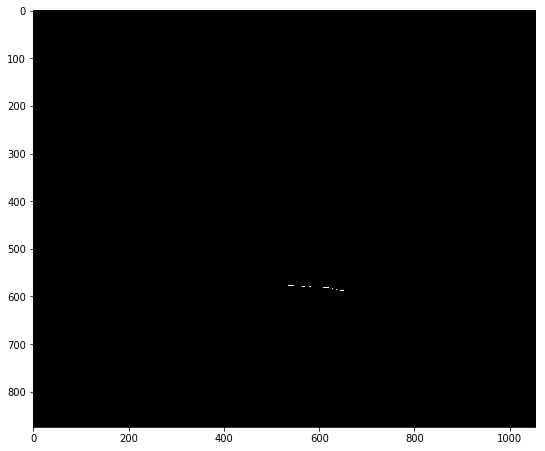

(874, 1054, 3)


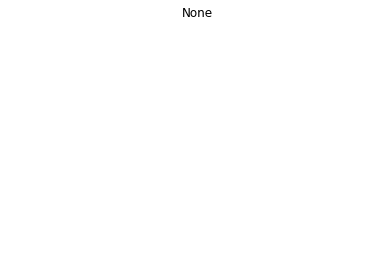

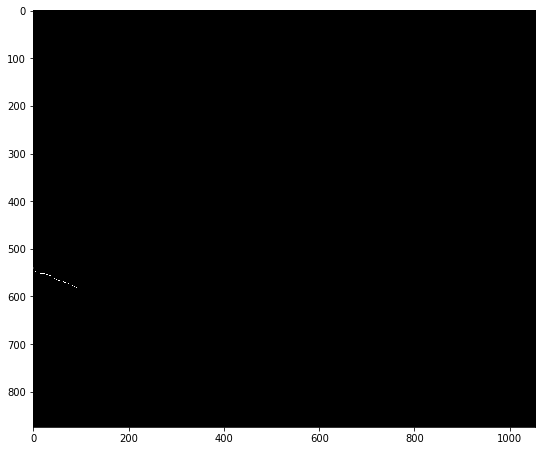

(874, 1054, 3)


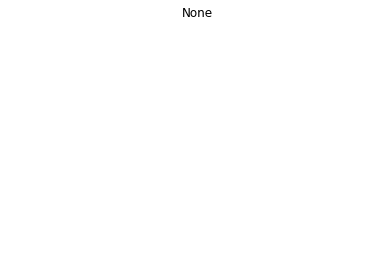

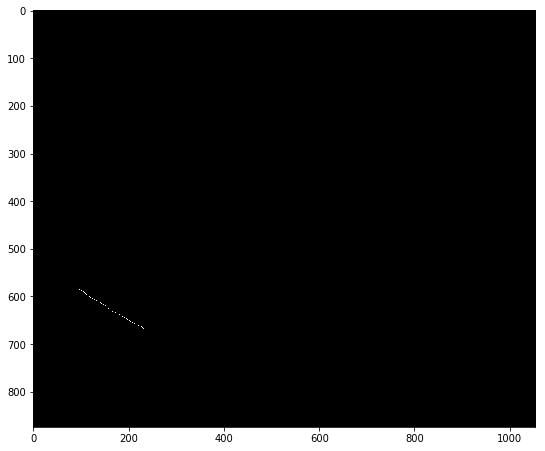

(874, 1054, 3)


In [15]:
# Hyperparam
help_functions.dir_checker('./pipe_result/'+name_experiment+'/')
sta_save_folder = './pipe_result/'+name_experiment+'/sta_result/'
help_functions.dir_checker(sta_save_folder)

sta_histo_eq_save_folder = './pipe_result/'+name_experiment+'/sta_result/histogram_equal/'
sta_clahe_save_folder = './pipe_result/'+name_experiment+'/sta_result/clahe/'
help_functions.dir_checker(sta_histo_eq_save_folder)
help_functions.dir_checker(sta_clahe_save_folder)

# Processing
sta_lists,sta_table = spatial_temporal_analysis(compensated_ori_imgs,labeled_vessel_map,proposed_vessel,
                          debug_flag=debug_flag, save_folder =  sta_save_folder)
    
#sta_lists,sta_table = spatial_temporal_analysis(ORI_VESSEL_IMGS[:,:,:,0],labeled_vessel_map,proposed_vessel,
#                          debug_flag=debug_flag, save_folder =  sta_save_folder)

if debug_flag ==True:
    for idx in range(np.shape(proposed_vessel)[0]):
        row, col = np.where(labeled_vessel_map == proposed_vessel[idx][1])
        temp_proposed_vessel_dist = first_dist_map[row,col]
        mean_proposed_distance = np.mean(temp_proposed_vessel_dist)
        mean_06_dist = float("{0:.6f}".format(float(mean_proposed_distance)))
        sta_table.loc[idx,'Vessel distance (px)' ] = mean_06_dist
        mm_distance = float("{0:.6f}".format(float(mean_proposed_distance / 550)))
        sta_table.loc[idx,'Vessel distance (mm)' ] = mm_distance
        
        sta_var_info = before_filter_vessel_idx[proposed_vessel[idx][1]][0]
        sta_table.loc[idx,'Variance' ] = sta_var_info
        sta_table.loc[idx,'Eq value' ] = proposed_vessel[idx][0]
        
        
        sta_table.to_excel(sta_save_folder + "sta_table.xlsx")  
        sta_table.to_csv(sta_save_folder + "sta_table.csv")  
        
        
        temp = np.zeros((SHAPE_IMGS[0], SHAPE_IMGS[1]), dtype= np.uint8)
        row, col = np.where(labeled_vessel_map == proposed_vessel[idx][1])
        temp[row,col] = 255
        help_functions.show_on_jupyter(temp, 'gray')

        temp2 = ORI_VESSEL_IMGS[0].copy()
        if idx==0:
            cv2.imwrite(sta_save_folder+'original_img.png',temp2)
        print(np.shape(temp2))
        temp2[row, col,:] = (0,0,255)
        #help_functions.show_on_jupyter(temp2)
        
        temp_sti_ = np.array(np.expand_dims(sta_lists[idx], -1),dtype=np.uint8)
        temp_sti= cv2.equalizeHist(temp_sti_)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        temp_sti2 = clahe.apply(temp_sti_)
        
        if idx <10 : 
            cv2.imwrite(sta_save_folder+'top_0'+str(idx)+'_img.png',temp2)
            cv2.imwrite(sta_histo_eq_save_folder +'0'+ str(idx) +'.png',temp_sti)
            cv2.imwrite(sta_clahe_save_folder +'0'+ str(idx) +'.png',temp_sti2)

        else:
            cv2.imwrite(sta_save_folder+'top_'+str(idx)+'_img.png',temp2)
            cv2.imwrite(sta_histo_eq_save_folder + str(idx) +'.png',temp_sti)
            cv2.imwrite(sta_clahe_save_folder + str(idx) +'.png',temp_sti2)
        

        

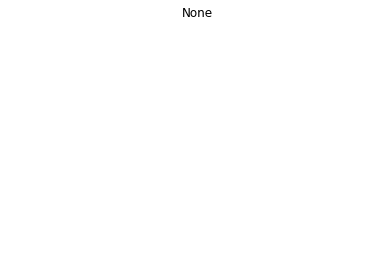

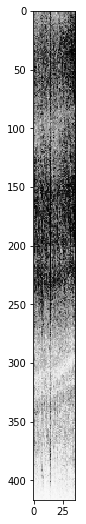

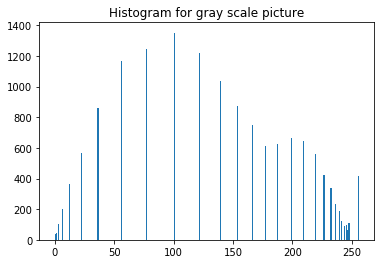

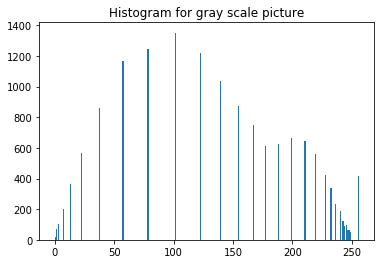

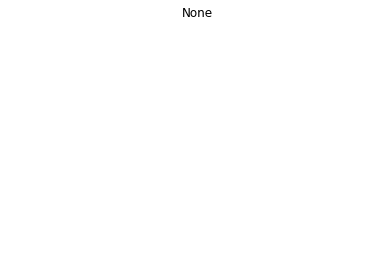

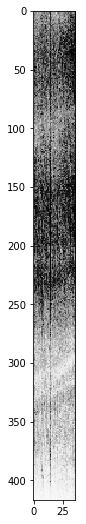

"\nclahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))\ntemp_sti2 = clahe.apply(temp_sti_)\nhelp_functions.show_on_jupyter(temp_sti2,'gray')\nhelp_functions.show_histogram(temp_sti2,'gray')\n\n\ntemp_sti3 = adjust_gamma(temp_sti_ ,gamma= 0.4 )\nhelp_functions.show_on_jupyter(temp_sti3,'gray')\nhelp_functions.show_histogram(temp_sti3,'gray')\n\ntemp_sti4 = adjust_gamma(temp_sti_ ,gamma= 0.5 )\nhelp_functions.show_on_jupyter(temp_sti4,'gray')\nhelp_functions.show_histogram(temp_sti4,'gray')\n\ntemp_sti5 = adjust_gamma(temp_sti_ ,gamma= 0.6 )\nhelp_functions.show_on_jupyter(temp_sti5,'gray')\nhelp_functions.show_histogram(temp_sti5,'gray')\n\n\ntemp_sti6 = adjust_gamma(temp_sti_ ,gamma= 1.5 )\nhelp_functions.show_on_jupyter(temp_sti6,'gray')\nhelp_functions.show_histogram(temp_sti6,'gray')"

In [16]:
#help_functions.show_histogram(sta_lists[1],'gray')
temp_sti_ = np.array(np.expand_dims(sta_lists[1], -1),dtype=np.uint8)
temp_sti7 = equalize_image(255 - sta_lists[1].astype(np.uint8))
help_functions.show_on_jupyter(temp_sti7,'gray')
help_functions.show_histogram(temp_sti7,'gray')

temp_sti= cv2.equalizeHist(255 - temp_sti_)
help_functions.show_histogram(temp_sti,'gray')
help_functions.show_on_jupyter(temp_sti,'gray')
'''
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
temp_sti2 = clahe.apply(temp_sti_)
help_functions.show_on_jupyter(temp_sti2,'gray')
help_functions.show_histogram(temp_sti2,'gray')


temp_sti3 = adjust_gamma(temp_sti_ ,gamma= 0.4 )
help_functions.show_on_jupyter(temp_sti3,'gray')
help_functions.show_histogram(temp_sti3,'gray')

temp_sti4 = adjust_gamma(temp_sti_ ,gamma= 0.5 )
help_functions.show_on_jupyter(temp_sti4,'gray')
help_functions.show_histogram(temp_sti4,'gray')

temp_sti5 = adjust_gamma(temp_sti_ ,gamma= 0.6 )
help_functions.show_on_jupyter(temp_sti5,'gray')
help_functions.show_histogram(temp_sti5,'gray')


temp_sti6 = adjust_gamma(temp_sti_ ,gamma= 1.5 )
help_functions.show_on_jupyter(temp_sti6,'gray')
help_functions.show_histogram(temp_sti6,'gray')'''




In [17]:
cv2.imwrite('temp_sti.png',sta_lists[5])
cv2.imwrite('temp_sti2.png',temp_sti)
cv2.imwrite('temp_sti3.png',temp_sti2)


True